In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


data_Lodear

In [2]:
import cv2
import os
import torch
from torch.utils import data
from torchvision import transforms
from nltk.tokenize import word_tokenize
import random
from PIL import Image
import numpy as np
class Dataset(data.Dataset):
    def __init__(self,images_folder,
                 data,
                 transform,
                 vocab,
                 imsize=(224,224),
                 shuffle=True,
                 tokenizer=word_tokenize
                ):
        self.image_folder=images_folder
        if shuffle:
            random.shuffle(data)
        self.data=data
        self.transform=transform
        self.imsize=imsize
        self.vocab=vocab
        self.tokenizer=tokenizer
    def load_data(self,batch_size=32):
        images,captions=[None]*batch_size,[None]*batch_size
        for i in range(self.__len__()):
            image,caption=self.__getitem__(i)
            c,h,w=image.size()
            images[i%batch_size]=image.view(-1,c,h,w)
            captions[i%batch_size]=caption
            if i>0 and i%batch_size==0:
                yield images,captions
#             if i>=self.__len__():
#                 break
            
    def __getitem__(self,index):
        data =self.data[index]
        image_name=data[0]
        image=cv2.imread(os.path.join(self.image_folder,image_name))
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image=cv2.resize(image,self.imsize)
        image=self.transform(Image.fromarray(image))
        caption= data[1]
        tokens = self.tokenizer(str(caption).lower())
        caption = []
#         caption.append(self.vocab(self.vocab.start_word))
        caption.extend([self.vocab(token) for token in tokens])
        caption.append(self.vocab(self.vocab.end_word))
        caption = torch.Tensor(caption).long()
        return image,caption
        
    def __len__(self):
        return len(self.data)

vocab

In [3]:
import nltk
import pickle
import os.path
from nltk.tokenize import word_tokenize
nltk.download("punkt")
from collections import Counter

class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        captions,
        vocab_file='./vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='../cocoapi/annotations/captions_train2014.json',
        vocab_from_file=False,
        tokenizer=nltk.tokenize.word_tokenize):
        """Initialize the vocabulary.
        Args:
          vocab_threshold: Minimum word count threshold.
          captions: list of captions 
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.captions=captions
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.tokenizer=tokenizer
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
#         self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        counter = Counter()
        for i, caption in enumerate(self.captions):
            tokens = self.tokenizer(caption.lower())
            counter.update(tokens)

            if i % 1000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(self.captions)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Training

In [4]:
import os

In [5]:
import cv2
import random
import numpy as np
import random

In [6]:
SEED=1234
np.random.seed(SEED)

In [7]:
import torch
from torch.utils import data
import torch.nn as nn

In [8]:
!pip install dataloader

  Created wheel for dataloader: filename=dataloader-2.0-cp36-none-any.whl size=10101 sha256=9ed0056f7e9b577a3bb5a428247eb445813c3651c6f55d72dcdb33c01223d3c2
  Stored in directory: /root/.cache/pip/wheels/3a/a0/74/7190a79f983c5276ddcfe888612746a633d8ed0c0eaf7fa42d
Successfully built dataloader


In [9]:
#from dataloader import Dataset
#from vocabulary import Vocabulary

In [10]:
dataset_folder="/content/drive/MyDrive/MyPro/flickr8k/images1"

In [11]:
!pip install bnltk

In [12]:
import json

In [13]:
dataset_folder="/content/drive/MyDrive/MyPro/flickr8k/images1/"

caption_json_path=dataset_folder+"captions1.json"

filenames_with_captions=json.load(open(caption_json_path))

from bnltk.tokenize import Tokenizers
t = Tokenizers()
tokenizer = t.bn_word_tokenizer

from sklearn.model_selection import train_test_split

train,test=train_test_split(filenames_with_captions,test_size=0.1)
train,valid=train_test_split(filenames_with_captions,test_size=0.1)

image_names=[]
all_captions=[]
train_with_captions=[]
val_with_captions=[]
test_with_captions=[]
image_folder= dataset_folder+"images/"
for filename_caption in train:
    image_name = filename_caption["filename"]
    captions=filename_caption["caption"]
    for caption in captions:
        train_with_captions.append((image_name,caption))
        all_captions.append(caption)
for filename_caption in valid:
    image_name = filename_caption["filename"]
    captions=filename_caption["caption"]
    for caption in captions:
        val_with_captions.append((image_name,caption))
        all_captions.append(caption)
for filename_caption in test:
    image_name = filename_caption["filename"]
    captions=filename_caption["caption"]
    for caption in captions:
        test_with_captions.append((image_name,caption))
        all_captions.append(caption)

vocab=Vocabulary(vocab_threshold=6,captions=all_captions,tokenizer=t.bn_word_tokenizer)

[0/20140] Tokenizing captions...
[1000/20140] Tokenizing captions...
[2000/20140] Tokenizing captions...
[3000/20140] Tokenizing captions...
[4000/20140] Tokenizing captions...
[5000/20140] Tokenizing captions...
[6000/20140] Tokenizing captions...
[7000/20140] Tokenizing captions...
[8000/20140] Tokenizing captions...
[9000/20140] Tokenizing captions...
[10000/20140] Tokenizing captions...
[11000/20140] Tokenizing captions...
[12000/20140] Tokenizing captions...
[13000/20140] Tokenizing captions...
[14000/20140] Tokenizing captions...
[15000/20140] Tokenizing captions...
[16000/20140] Tokenizing captions...
[17000/20140] Tokenizing captions...
[18000/20140] Tokenizing captions...
[19000/20140] Tokenizing captions...
[20000/20140] Tokenizing captions...


In [14]:
from torchvision import transforms

# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(224),                           # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
])
transform_test = transforms.Compose([ 
    transforms.Resize(224),                          # smaller edge of image resized to 256
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
])

In [15]:
dataset= Dataset(image_folder,train_with_captions,transform_train,vocab,tokenizer=t.bn_word_tokenizer)
valid_dataset= Dataset(image_folder,val_with_captions,transform_test,vocab,tokenizer=t.bn_word_tokenizer)
test_dataset= Dataset(image_folder,test_with_captions,transform_test,vocab,tokenizer=t.bn_word_tokenizer)

In [16]:
#from model import EncoderCNN,EncoderVGG,EncoderVGGAtt
#from model import DecoderRNN,DecoderRNNAttention

model

In [17]:
class EncoderVGG(nn.Module):
    def __init__(self):
        super(EncoderVGG, self).__init__()
        model = models.vgg16(pretrained=True)
        for param in model.parameters():
            param.requires_grad_(False)
        
        normal_modules = list(model.features.children())+list(model.avgpool.children())
        classifier_modules=list(model.classifier.children())[:-3]
        self.conv_model = nn.Sequential(*normal_modules)
        self.classifier_model=nn.Sequential(*classifier_modules)
#         self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.conv_model(images)
        features = features.view(features.size(0),-1)
        features = self.classifier_model(features)
        return features

In [18]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size,batch_size):
        ''' Initialize the layers of this model.'''
        super().__init__()
        self.hidden_size = hidden_size    
        # Embedding layer that turns words into a vector of a specified size
        self.word_embeddings = nn.Embedding(vocab_size, embed_size)
        # The LSTM takes embedded word vectors (of a specified size) as input
        # and outputs hidden states of size hidden_dim
        self.lstm = nn.LSTM(input_size=embed_size, \
                            hidden_size=hidden_size, # LSTM hidden units 
                            num_layers=1, # number of LSTM layer
                            bias=True, # use bias weights b_ih and b_hh
                            batch_first=True,  # input & output will have batch size as 1st dimension
                            dropout=0, # Not applying dropout 
                            bidirectional=False, # unidirectional LSTM
                           )
        
        # The linear layer that maps the hidden state output dimension
        # to the number of words we want as output, vocab_size
        self.linear = nn.Linear(hidden_size, vocab_size)                     
        self.batch_size=batch_size
        # initialize the hidden state
        # self.hidden = self.init_hidden()
        
    def init_hidden(self, batch_size):
        """ At the start of training, we need to initialize a hidden state;
        there will be none because the hidden state is formed based on previously seen data.
        So, this function defines a hidden state with all zeroes
        The axes semantics are (num_layers, batch_size, hidden_dim)
        """
        return (torch.zeros((1, batch_size, self.hidden_size), device=device), \
                torch.zeros((1, batch_size, self.hidden_size), device=device))

    def forward(self, features, captions):
        """ Define the feedforward behavior of the model """
        
        # Discard the <end> word to avoid predicting when <end> is the input of the RNN
#         captions = captions[:, :-1]     
        input_captions=[caption[:-1] for caption in captions]


        input_captions=nn.utils.rnn.pad_sequence(input_captions,batch_first=True)
#         print(input_captions.size())
        input_captions_lengths=[len(input_caption)+1 for input_caption in input_captions]
        embeddings = self.word_embeddings(input_captions) # embeddings new shape : (batch_size, captions length - 1, embed_size)
        
        # Initialize the hidden state
        batch_size = features.shape[0] # features is of shape (batch_size, embed_size)
        self.hidden = self.init_hidden(self.batch_size) 
                
        # Create embedded word vectors for each word in the captions
        

        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1) # embeddings new shape : (batch_size, caption length, embed_size)

        embeddings=nn.utils.rnn.pack_padded_sequence(embeddings,lengths=input_captions_lengths,batch_first=True,enforce_sorted=False)
        # Get the output and hidden state by passing the lstm over our word embeddings
        # the lstm takes in our embeddings and hidden state
        lstm_out, self.hidden = self.lstm(embeddings, self.hidden) # lstm_out shape : (batch_size, caption length, hidden_size)
        lstm_out=nn.utils.rnn.pad_packed_sequence(lstm_out,batch_first=True)

        #Fully connected layer
        outputs = self.linear(lstm_out[0]) # outputs shape : (batch_size, caption length, vocab_size)

        return outputs

break

In [19]:
batch_size = 128           # batch size
vocab_threshold = 6        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 4096         # dimensionality of image and word embeddings
hidden_size = 512         # number of features in hidden state of the RNN decoder
num_epochs = 5            # number of training epochs (1 for testing)
save_every = 1             # determines frequency of saving model weights
print_every = 200          # determines window for printing average loss
log_file = 'training_log_attention.txt'       # name of file with saved training loss and perplexity
val_log_file = 'validation_log_attention.txt'
vocab_size=len(vocab)

In [20]:
from torchvision import models

In [21]:
encoder = EncoderVGG()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size,batch_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [22]:
params = list(decoder.parameters())# + list(encoder.embed.parameters()) 
optimizer = torch.optim.Adam(params, lr=0.001,weight_decay=0.001)

In [23]:
validation_loss_min = np.inf

In [24]:
train_losses=[]
validation_losses=[]

In [25]:

f = open(log_file, 'w')
validation_f=open(val_log_file,'w')
i_step=0
print_every=100

for epoch in range(1, num_epochs+1):
    try:
        for images,captions in dataset.load_data(batch_size):
            images=torch.cat(images)


            # Move batch of images and captions to GPU if CUDA is available.
            images_gpu = images.to(device)
            captions_gpu = [caption.to(device) for caption in captions]
            captions_padded=nn.utils.rnn.pad_sequence(captions_gpu,batch_first=True)
            # Zero the gradients.
            decoder.zero_grad()
            encoder.zero_grad()

            # Pass the inputs through the CNN-RNN model.
            features = encoder(images_gpu)
            outputs = decoder(features, captions_gpu)

            # Calculate the batch loss.
    #         print("outputs.shape: ", outputs.shape)
            loss = criterion(outputs.contiguous().view(-1, vocab_size), captions_padded.view(-1))

            # Backward pass.
            loss.backward()

            # Update the parameters in the optimizer.
            optimizer.step()

            # Get training statistics.
            stats = 'Epoch [%d/%d], Step [%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, loss.item(), np.exp(loss.item()))

            # Print training statistics (on same line).
            print('\r' + stats, end="")


            # Print training statistics to file.
            f.write(stats + '\n')
            f.flush()

            # Print training statistics (on different line).
            if i_step % print_every == 0:
                print('\r' + stats)
            i_step=i_step+1
        train_losses.append(loss.item())
    except RuntimeError:
        print(captions,i_step)
        pass
    validation_loss=0
    validation_iter=1
    for images,captions in valid_dataset.load_data(batch_size):
        images=torch.cat(images)
        

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = [caption.to(device) for caption in captions]
        captions_padded=nn.utils.rnn.pad_sequence(captions,batch_first=True)
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)

        
        # Calculate the batch loss.
#         print("outputs.shape: ", outputs.shape)
        loss = criterion(outputs.contiguous().view(-1, vocab_size), captions_padded.view(-1))
        validation_loss=validation_loss+loss.item()
        validation_iter=validation_iter+1
        # Get training statistics.
    validation_loss = validation_loss/validation_iter
    validation_losses.append(validation_loss)
    stats = 'Epoch [%d/%d], Step [%d], Validation Loss: %.4f, Perplexity: %5.4f\n' % (epoch, num_epochs, validation_iter, validation_loss, np.exp(validation_loss))
    if validation_loss<validation_loss_min:
        print("\nmodel improved!")
        torch.save(decoder.state_dict(), os.path.join('/content/drive/MyDrive/MyPro/bengali_models_decoder', 'decoder.pkl'))
        torch.save(encoder.state_dict(), os.path.join('/content/drive/MyDrive/MyPro/bengali_models_encoder', 'encoder.pkl'))
        validation_loss_min=validation_loss
    else:
        print("\nnot improved yet!")
    # Print training statistics (on same line).
    print('\n' + stats, end="")


    # Print training statistics to file.
    validation_f.write(stats + '\n')
    validation_f.flush()

    # Print training statistics (on different line).



# Close the training log file.
f.close()
validation_f.close()



Epoch [1/5], Step [0], Loss: 7.2137, Perplexity: 1357.9245
Epoch [1/5], Step [100], Loss: 1.0068, Perplexity: 2.7369
Epoch [1/5], Step [127], Loss: 1.4438, Perplexity: 4.2366
model improved!

Epoch [1/5], Step [15], Validation Loss: 1.1361, Perplexity: 3.1147
Epoch [2/5], Step [200], Loss: 1.3435, Perplexity: 3.8323
Epoch [2/5], Step [255], Loss: 1.3483, Perplexity: 3.8510
model improved!

Epoch [2/5], Step [15], Validation Loss: 1.0742, Perplexity: 2.9277
Epoch [3/5], Step [300], Loss: 1.2803, Perplexity: 3.5978
Epoch [3/5], Step [383], Loss: 1.3177, Perplexity: 3.7349
model improved!

Epoch [3/5], Step [15], Validation Loss: 1.0554, Perplexity: 2.8730
Epoch [4/5], Step [400], Loss: 1.1444, Perplexity: 3.1406
Epoch [4/5], Step [500], Loss: 0.9926, Perplexity: 2.6982
Epoch [4/5], Step [511], Loss: 1.3002, Perplexity: 3.6702
model improved!

Epoch [4/5], Step [15], Validation Loss: 1.0476, Perplexity: 2.8507
Epoch [5/5], Step [600], Loss: 1.1398, Perplexity: 3.1262
Epoch [5/5], Step [63

In [26]:
#encoder.load_state_dict(torch.load("/content/drive/MyDrive/MyPro/bengali_models_encoder/encoder-1.pkl", map_location= torch.device('cpu')))#, map_location= torch.device('cpu')))
#decoder.load_state_dict(torch.load("/content/drive/MyDrive/MyPro/bengali_models_decoder/decoder-5.pkl",map_location= torch.device('cpu')))#,map_location= torch.device('cpu')))

#encoder.load_state_dict(torch.load("/content/drive/MyDrive/MyPro/bengali_models_encoder/encoder-7.pkl"))#,map_location="cpu"))
#decoder.load_state_dict(torch.load("/content/drive/MyDrive/MyPro/bengali_models_decoder/decoder-7.pkl"))#,map_location="cpu"))

In [27]:
!pip install matplotlib

In [28]:
import matplotlib.pyplot as plt

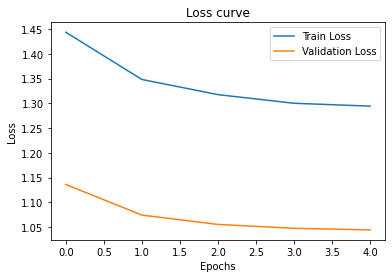

In [29]:
plt.plot(train_losses,label="Train Loss")
plt.plot(validation_losses,label="Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss curve")
plt.legend()

In [54]:
import cv2

work_image=cv2.imread("/content/drive/MyDrive/MyPro/testfig/57.png")

work_image= cv2.resize(work_image,(224,224))

work_image= cv2.cvtColor(work_image,cv2.COLOR_BGR2RGB)

work_image=work_image/255

work_image_tensor= torch.from_numpy(work_image)

work_image_tensor.size()

work_image_tensor=work_image_tensor.permute((2,0,1))

In [38]:
def sample(inputs):
    " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "


    output = []
    batch_size = inputs.shape[0] # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
    hidden = decoder.init_hidden(batch_size) # Get initial hidden state of the LSTM

    while True:
        lstm_out, hidden = decoder.lstm(inputs, hidden) # lstm_out shape : (1, 1, hidden_size)
        outputs = decoder.linear(lstm_out)  # outputs shape : (1, 1, vocab_size)
        outputs= nn.functional.softmax(outputs,dim=2)
        outputs = outputs.squeeze(1) # outputs shape : (1, vocab_size)
        _, max_indice = torch.max(outputs, dim=1) # predict the most likely next word, max_indice shape : (1)

        output.append(max_indice.cpu().numpy()[0].item()) # storing the word predicted

        if (max_indice == 0):
            # We predicted the <end> word, so there is no further prediction to do
            break

        ## Prepare to embed the last predicted word to be the new input of the lstm
        inputs = decoder.word_embeddings(max_indice) # inputs shape : (1, embed_size)
        inputs = inputs.unsqueeze(1) # inputs shape : (1, 1, embed_size)

    return output

In [32]:
import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='/content/drive/MyDrive/MyPro/flickr8k/kalpurush.ttf')

In [33]:
target_folder="/content/drive/MyDrive/MyPro/test_result06"

In [34]:
"""
count=0
for validation_image,validation_caption in test_dataset:
    encoder.eval()
    decoder.eval()
    validation_image=validation_image.to(device)
    validation_image=validation_image.view(1,3,224,224)
    actual_outputs=validation_caption.cpu().numpy().tolist()
    features=encoder(validation_image)
    outputs=sample(features.view(1,1,4096))
    output_words=[vocab.idx2word[output] for output in outputs]
    plt.figure()
    plt.imshow(validation_image[0].cpu().numpy().transpose((1,2,0)))
    plt.title(" ".join(output_words),fontproperties=prop)
    plt.savefig("{}/{}.jpg".format(target_folder,count))
    count=count+1
    #if count>100:
     #    break
     
     """

'\ncount=0\nfor validation_image,validation_caption in test_dataset:\n    encoder.eval()\n    decoder.eval()\n    validation_image=validation_image.to(device)\n    validation_image=validation_image.view(1,3,224,224)\n    actual_outputs=validation_caption.cpu().numpy().tolist()\n    features=encoder(validation_image)\n    outputs=sample(features.view(1,1,4096))\n    output_words=[vocab.idx2word[output] for output in outputs]\n    plt.figure()\n    plt.imshow(validation_image[0].cpu().numpy().transpose((1,2,0)))\n    plt.title(" ".join(output_words),fontproperties=prop)\n    plt.savefig("{}/{}.jpg".format(target_folder,count))\n    count=count+1\n    #if count>100:\n     #    break\n     \n     '

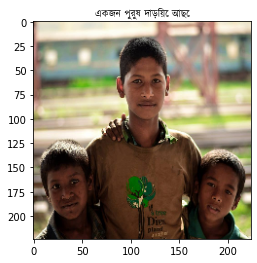

In [55]:
work_image_tensor.float().type()

encoder.eval()
decoder.eval()
validation_image=work_image_tensor.to(device)
validation_image=validation_image.view(1,3,224,224)
features=encoder(validation_image.float())
outputs=sample(features.view(1,1,4096))
output_words=[vocab.idx2word[output] for output in outputs]
plt.figure()
plt.imshow(validation_image[0].cpu().numpy().transpose((1,2,0)))
plt.title(" ".join(output_words[:-1]),fontproperties=prop)
plt.savefig("/content/drive/MyDrive/MyPro/savefig")
#.format(target_folder,count))